In [1]:
import pandas as pd
import csv
from pathlib import Path
import json
import numpy as np
from datetime import datetime
import time
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.graph_objects as go
from matplotlib import rc

In [2]:
root_path = ###deleted for security reasons###
out_path = ###deleted for security reasons###
pic_path = ###deleted for security reasons###

# import data

## cofacts_truth_score

In [3]:
cofacts_truth_score = pd.read_csv(out_path/'cofacts_truth_score_20220319-20220513.csv')

In [4]:
rumor_article = set(cofacts_truth_score[cofacts_truth_score['article_type_count']=='rumor or opinion']['article_id'])
print(len(rumor_article))

8995


## owd_stats

In [5]:
taiwan = pd.read_csv(root_path/'tw_covid_daily_new_cases.csv')

In [6]:
taiwan.head(2)

,location,date,new_cases
0,Taiwan,2022-03-19,126.0
1,Taiwan,2022-03-20,121.0


# cofacts

In [33]:
def define_time_cat(createdAt):
    if createdAt >= '2022-03-19':
        return 'new'
    else:
        return 'old'

In [34]:
def mapping_rumor(article_id):
    if article_id in rumor_article:
        return 'rumor'
    else:
        return 'else'

In [35]:
cofacts_daily_views = []
tformat = "%Y-%m-%d"
with open(root_path/'cofacts_20220319-20220513.json' , 'r', encoding='big5') as reader:
    data = json.loads(reader.read())
    for idx, article in enumerate(data):
        article_type = mapping_rumor(article['id'])
        create_time = datetime.strptime(article['createdAt'].split('T')[0], tformat)
        create_type = define_time_cat(str(create_time))
        for d in article['stats']:
            ori_time = datetime.strptime(d['date'].split('T')[0], tformat)
            if ori_time >= datetime.strptime('2022-03-19', tformat) and ori_time <= datetime.strptime('2022-05-13', tformat):
                view_list = [v for v in d.values()]
                cofacts_daily_views.append([article['id'], article_type, create_time, create_type,
                                            d['date'].split('T')[0], sum([0 if value==None else value for value in view_list[:-1]])])

In [36]:
cofacts_daily_views = pd.DataFrame(cofacts_daily_views, 
                                   columns=['article_id', 'article_type', 'createdAt', 'create_type', 
                                            'date', 'article_views'])

In [37]:
cofacts_daily_views.head(2)

,article_id,article_type,createdAt,create_type,date,article_views
0,140lw1792lqrl,rumor,2019-01-31,old,2022-03-19,6
1,140lw1792lqrl,rumor,2019-01-31,old,2022-03-20,3


# COVID

In [38]:
covid_article = []
with open(root_path/'cofacts_covid_20220319-20220513.json' , 'r', encoding='big5') as reader:
    data = json.loads(reader.read())
#     for idx, article in enumerate(data):
    for k in data.keys():
        covid_article.append([data[k]['article_id'], data[k]['category']])
        
covid_article = pd.DataFrame(covid_article, columns=['article_id', 'category'])

In [39]:
covid_daily_views =  covid_article.merge(cofacts_daily_views, how='left')

In [40]:
#整理x軸
date = pd.date_range('2022-03-19', '2022-05-13')
date = pd.DataFrame(date, columns=['date'])
date.date = date.date.astype('str')

In [41]:
covid_daily_views = date.merge(covid_daily_views, how='left')

In [42]:
set(covid_daily_views.category)

{'covid'}

In [65]:
covid_daily_views

,date,article_id,category,article_type,createdAt,create_type,article_views
0,2022-03-19,1g9ho0x9e8iyi,covid,rumor,2020-01-30,old,2
1,2022-03-19,p550nlkgl25o,covid,rumor,2020-01-29,old,6
2,2022-03-19,vyh1eikhvl2u,covid,else,2020-01-25,old,3
3,2022-03-19,22a5jdphsqln4,covid,rumor,2020-01-25,old,3
4,2022-03-19,4cz8cqv0905m,covid,rumor,2020-01-23,old,3
...,...,...,...,...,...,...,...
47863,2022-05-13,2o7ek42ogmkja,covid,rumor,2022-05-01,new,165
47864,2022-05-13,21kv2w22ilv4r,covid,else,2022-05-01,new,4
47865,2022-05-13,2bgsy3fwz0s6h,covid,rumor,2022-05-01,new,20
47866,2022-05-13,3g2juejernwyb,covid,rumor,2022-05-01,new,379


# vis: new vs old

In [43]:
old_covid_daily_views = covid_daily_views[covid_daily_views.create_type=='old']
new_covid_daily_views = covid_daily_views[covid_daily_views.create_type=='new']

In [59]:
old_covid_daily_views = date.merge(old_covid_daily_views[['date', 'article_views']], how='left')\
                        .groupby(by='date', as_index=False).sum()
new_covid_daily_views = date.merge(new_covid_daily_views[['date', 'article_views']], how='left')\
                        .groupby(by='date', as_index=False).sum()

In [70]:
old_covid_daily_views = old_covid_daily_views.rename(columns={'article_views':'old_article_views'})
new_covid_daily_views = new_covid_daily_views.rename(columns={'article_views':'new_article_views'})

In [72]:
on_covid_daily_views = old_covid_daily_views.merge(new_covid_daily_views)

In [73]:
on_covid_daily_views['no_total'] = on_covid_daily_views['old_article_views'] + on_covid_daily_views['new_article_views']
on_covid_daily_views['new_prop'] = on_covid_daily_views['new_article_views']/on_covid_daily_views['no_total']

In [96]:
on_covid_daily_views['old_article_views'].sum()/(on_covid_daily_views['old_article_views'].sum()+on_covid_daily_views['new_article_views'].sum())

0.43976655778156704

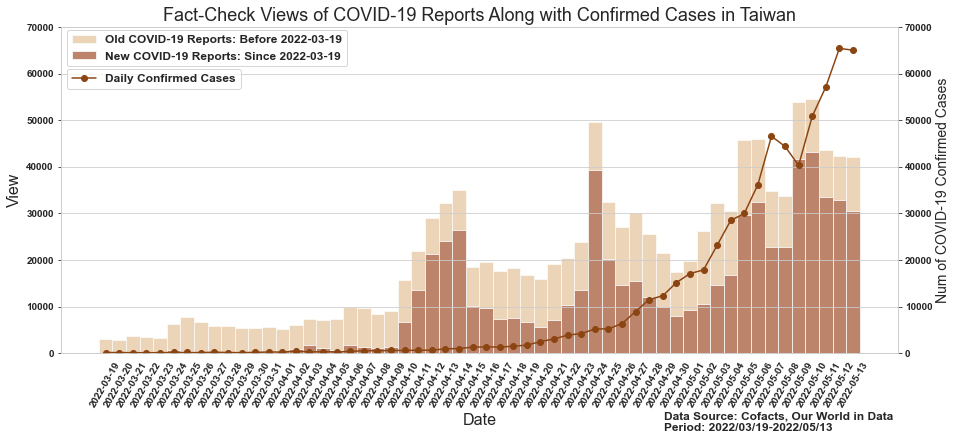

In [97]:
fig, ax = plt.subplots(1,1,figsize=(15,6), facecolor='white', edgecolor='white')
ax.grid()
sns.set_style('whitegrid')
rc('font', weight='bold')

# #bar chart
bars1 = on_covid_daily_views['old_article_views'].tolist()
bars2 = on_covid_daily_views['new_article_views'].tolist()
bars = np.add(bars1, bars2).tolist()

# The position of the bars on the x-axis
r = list(range(0, len(date)))
 
# Names of group and bar width
names = list(covid_daily_views['date'])
barWidth = 1

plt.bar(r, bars1, bottom=bars2, color='burlywood', edgecolor='white', width=barWidth, alpha=0.6, 
        label='Old COVID-19 Reports: Before 2022-03-19')
plt.bar(r, bars2, color='sienna', edgecolor='white', width=barWidth, alpha=0.7, 
        label='New COVID-19 Reports: Since 2022-03-19')

plt.legend(fontsize = 12, bbox_to_anchor=(0,1.01), loc='upper left')

plt.ylabel('View',fontsize = 16)

ax.set_xlabel('Date', fontsize = 16)
plt.xticks(rotation=60)
ax.set_ylim([0,70000])

#line cahrt
ax1= ax.twinx()
x=taiwan['date']
y=taiwan['new_cases']
ax1.plot(x,y,'-o',  color='saddlebrown', linewidth=1.5, label='Daily Confirmed Cases', alpha=1)

ax1.set_xlabel('Date', fontsize = 16)
ax1.set_ylim([0,70000])
ax1.set_ylabel('Num of COVID-19 Confirmed Cases',fontsize = 14)
ax1.legend(fontsize = 12, bbox_to_anchor=(0,0.89), loc='upper left')


save_name = 'Fact-Check Views of COVID-19 Reports Along with Confirmed Cases in Taiwan'
plt.title(save_name, fontsize = 18)
plt.annotate('Data Source: Cofacts, Our World in Data\nPeriod: 2022/03/19-2022/05/13', 
             (0.615,0.01), xycoords='figure fraction', fontsize=12)

# plt.savefig(pic_path/f'cofacts_{save_name}_by_time.png',
#             bbox_inches='tight')

plt.show()

# vis: rumor vs else

In [24]:
covid_daily_views.columns

Index(['date', 'article_id', 'category', 'article_type', 'createdAt',
       'create_type', 'article_views'],
      dtype='object')

In [25]:
else_covid_daily_views = covid_daily_views[covid_daily_views.article_type=='else']
rumor_covid_daily_views = covid_daily_views[covid_daily_views.article_type=='rumor']

In [26]:
else_covid_daily_views = else_covid_daily_views[['date', 'article_views']]\
                        .groupby(by='date', as_index=False).sum()
rumor_covid_daily_views = rumor_covid_daily_views[['date', 'article_views']]\
                        .groupby(by='date', as_index=False).sum()

In [27]:
else_covid_daily_views['article_views'].sum()

432446

In [28]:
rumor_covid_daily_views['article_views'].sum()

715247

In [64]:
else_covid_daily_views['article_views'].sum()/rumor_covid_daily_views['article_views'].sum()

0.6046107148998877

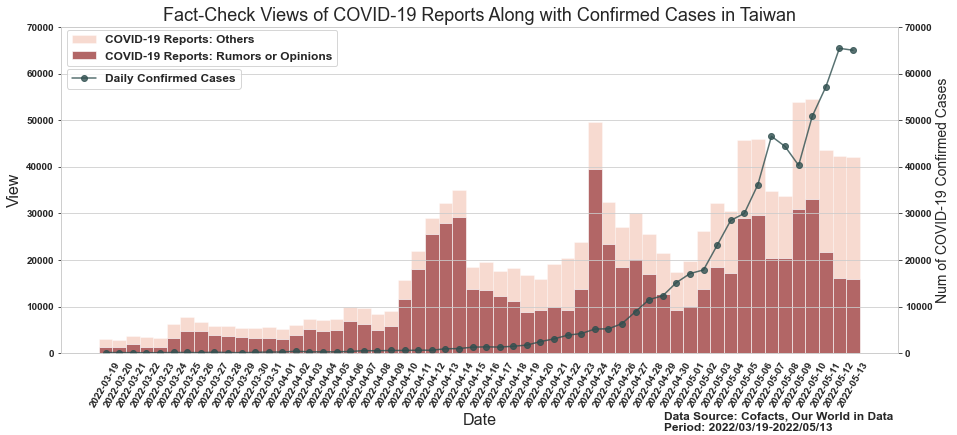

In [30]:
fig, ax = plt.subplots(1,1,figsize=(15,6), facecolor='white', edgecolor='white')
ax.grid()
sns.set_style('whitegrid')
rc('font', weight='bold')

# #bar chart
bars1 = else_covid_daily_views['article_views'].tolist()
bars2 = rumor_covid_daily_views['article_views'].tolist()
bars = np.add(bars1, bars2).tolist()

# The position of the bars on the x-axis
r = list(range(0, len(date)))
 
# Names of group and bar width
names = list(covid_daily_views['date'])
barWidth = 1

plt.bar(r, bars1, bottom=bars2, color='darksalmon', edgecolor='white', width=barWidth, alpha=0.35, label='COVID-19 Reports: Others')
plt.bar(r, bars2, color='maroon', edgecolor='white', width=barWidth, alpha=0.6, label='COVID-19 Reports: Rumors or Opinions')

plt.legend(fontsize = 12, bbox_to_anchor=(0,1.01), loc='upper left')

plt.ylabel('View',fontsize = 16)

ax.set_xlabel('Date', fontsize = 16)
plt.xticks(rotation=60)
ax.set_ylim([0,70000])

#line cahrt
ax1= ax.twinx()
x=taiwan['date']
y=taiwan['new_cases']
ax1.plot(x,y,'-o',  color='darkslategrey', linewidth=1.5, label='Daily Confirmed Cases', alpha=0.8)

ax1.set_xlabel('Date', fontsize = 16)
ax1.set_ylim([0,70000])
ax1.set_ylabel('Num of COVID-19 Confirmed Cases',fontsize = 14)
ax1.legend(fontsize = 12, bbox_to_anchor=(0,0.89), loc='upper left')


save_name = 'Fact-Check Views of COVID-19 Reports Along with Confirmed Cases in Taiwan'
plt.title(save_name, fontsize = 18)
plt.annotate('Data Source: Cofacts, Our World in Data\nPeriod: 2022/03/19-2022/05/13', 
             (0.615,0.01), xycoords='figure fraction', fontsize=12)

# plt.savefig(pic_path/f'cofacts_{save_name}_by_time.png',
#             bbox_inches='tight')

plt.show()